### Install Requirements Cell

This code installs all required Python packages listed in the `requirements.txt` file.

- `import subprocess, sys`  
  Imports standard libraries used to run system commands from Python.

- `print("📦 Installing requirements...")`  
  Displays a message indicating that the installation has started.

- `subprocess.check_call([sys.executable, "-m", "pip", "install", "-r", "requirements.txt"])`  
  Runs `pip install -r requirements.txt` using the current Python interpreter to ensure packages are installed in the correct environment.

- `print("✅ Requirements installed!")`  
  Confirms that the installation finished successfully.


In [1]:
# ---------------- Install Requirements ----------------
import subprocess
import sys

print("📦 Installing requirements...")
subprocess.check_call([sys.executable, "-m", "pip", "install", "-r", "requirements.txt"])
print("✅ Requirements installed!\n")

📦 Installing requirements...
✅ Requirements installed!



### FastAPI Server Runner

This code starts a **FastAPI** application inside a Jupyter Notebook by running **Uvicorn** in a **background thread**.

**What it does:**
- Imports required modules (`uvicorn`, `threading`, `time`)
- Defines a global `server` variable to control the Uvicorn server
- `start_server()`:
  - Configures Uvicorn to run the FastAPI app (`main:app`)
  - Runs the server on `127.0.0.1:8000`
- Starts the server in a **daemon thread** so the notebook does not block
- Waits 1 second to ensure the server is ready
- Prints the API documentation URL (`/docs`)
- `stop_server()`:
  - Gracefully stops the server by setting `server.should_exit = True`
  - Joins the thread and confirms shutdown

**Usage:**
- Run the cell to start the FastAPI server
- Open: `http://127.0.0.1:8000/docs`
- Call `stop_server()` to stop it safely


In [1]:
# ---------------- FastAPI Init ----------------

import uvicorn
import threading
import time

# ----------------- Server handle -----------------
server = None  # global

def start_server():
    global server
    config = uvicorn.Config("main:app", host="127.0.0.1", port=8000, reload=False)
    server = uvicorn.Server(config)
    server.run()  # blocking call

# ----------------- Start server thread -----------------
thread = threading.Thread(target=start_server, daemon=True)
thread.start()
time.sleep(1)
print("✅ FastAPI server should be running now!")
print("🌐 Open your browser: http://127.0.0.1:8000/docs")

# ----------------- Stop function -----------------
def stop_server():
    global server
    if server:
        print("🛑 Stopping FastAPI server...")
        server.should_exit = True  # uvicorn خودش می‌بینه و می‌بنده
        thread.join()
        print("✅ FastAPI server stopped.")
    else:
        print("⚠️ Server not running.")


✅ FastAPI server should be running now!
🌐 Open your browser: http://127.0.0.1:8000/docs


INFO:     Started server process [311624]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://127.0.0.1:8000 (Press CTRL+C to quit)


### What this code does

This code **fetches and caches all posts from a Telegram channel** (by username) and returns them as a Pandas DataFrame.

**Main steps:**
1. **Configuration:**  
   Sets database path, API endpoint, pagination size, cache duration (24 hours), and UTC timezone.

2. **Caching logic:**  
   - Uses a **SQLite database** to store previously fetched messages.
   - If a message was fetched within the last 24 hours, it is loaded from the cache instead of calling the API again.

3. **Crawling the API:**  
   - Requests messages page by page from a local API (`/read`).
   - Stops when there are no more messages or an error occurs.

4. **Database update:**  
   - Inserts new or updated messages into the database with a `fetched_at` timestamp.

5. **DataFrame creation:**  
   - Combines all messages into a Pandas DataFrame.
   - Converts dates to UTC, sorts messages by newest first.

6. **Reporting:**  
   - Prints a crawl summary (pages loaded, API vs cache usage, total posts).

Finally, the function is called for the channel **`ostad_elmosi`**, and the server is stopped after crawling.


In [25]:
import pandas as pd
import sqlite3
import requests
import re
from datetime import datetime, timedelta, timezone

DB_PATH = "data/data.db"
API_URL = "http://localhost:8000/read"
PER_PAGE = 100
CACHE_HOURS = 24
UTC = timezone.utc

# ------------------- Crawl & Cache -------------------
def load_full_channel_history(username: str) -> pd.DataFrame:
    conn = sqlite3.connect(DB_PATH)
    cursor = conn.cursor()
    now = datetime.now(UTC)
    cache_limit = now - timedelta(hours=CACHE_HOURS)
    all_posts = []
    page = 1
    stats = {"from_api": 0, "from_cache": 0, "pages_loaded": 0}

    while True:
        params = {"username": username, "page": page, "per_page": PER_PAGE}
        try:
            resp = requests.get(API_URL, params=params, timeout=10)
        except requests.RequestException as e:
            print(f"❌ Request failed on page {page}: {e}")
            break
        if resp.status_code >= 500:
            print(f"🛑 Server error on page {page}, stopping crawl.")
            break
        if resp.status_code != 200:
            print(f"⚠️ Status {resp.status_code} on page {page}, stopping.")
            break

        posts = resp.json()
        if not posts:
            print(f"📭 No more posts on page {page}.")
            break

        stats["pages_loaded"] += 1

        for msg in posts:
            message_id = msg["message_id"]
            cursor.execute(
                "SELECT text, date, fetched_at FROM posts WHERE channel_username=? AND message_id=?",
                (username, message_id),
            )
            row = cursor.fetchone()
            if row:
                fetched_at = datetime.fromisoformat(row[2])
                if fetched_at.tzinfo is None:
                    fetched_at = fetched_at.replace(tzinfo=UTC)
                if fetched_at > cache_limit:
                    all_posts.append((username, message_id, row[0], row[1], fetched_at))
                    stats["from_cache"] += 1
                    continue

            cursor.execute(
                """
                INSERT OR REPLACE INTO posts
                (channel_username, message_id, text, date, fetched_at)
                VALUES (?, ?, ?, ?, ?)
                """,
                (username, message_id, msg["message"], msg["date"], now.isoformat()),
            )
            all_posts.append((username, message_id, msg["message"], msg["date"], now))
            stats["from_api"] += 1

        conn.commit()
        page += 1

    conn.close()

    df = pd.DataFrame(all_posts, columns=["channel_username", "message_id", "text", "date", "fetched_at"])
    df["date"] = pd.to_datetime(df["date"], utc=True)
    df = df.sort_values("date", ascending=False)
    print("\n📊 Crawl Report")
    print("────────────────────────")
    print(f"📄 Pages loaded     : {stats['pages_loaded']}")
    print(f"🌐 Posts from API   : {stats['from_api']}")
    print(f"💾 Posts from cache : {stats['from_cache']}")
    print(f"📦 Total posts      : {len(df)}")
    return df
    
df = load_full_channel_history("ostad_elmosi")
stop_server()

INFO:     127.0.0.1:50892 - "GET /read?username=ostad_elmosi&page=1&per_page=100 HTTP/1.1" 200 OK
INFO:     127.0.0.1:42414 - "GET /read?username=ostad_elmosi&page=2&per_page=100 HTTP/1.1" 200 OK
INFO:     127.0.0.1:42430 - "GET /read?username=ostad_elmosi&page=3&per_page=100 HTTP/1.1" 200 OK
INFO:     127.0.0.1:42442 - "GET /read?username=ostad_elmosi&page=4&per_page=100 HTTP/1.1" 200 OK
INFO:     127.0.0.1:42454 - "GET /read?username=ostad_elmosi&page=5&per_page=100 HTTP/1.1" 200 OK
INFO:     127.0.0.1:42470 - "GET /read?username=ostad_elmosi&page=6&per_page=100 HTTP/1.1" 200 OK
INFO:     127.0.0.1:42474 - "GET /read?username=ostad_elmosi&page=7&per_page=100 HTTP/1.1" 200 OK
INFO:     127.0.0.1:42478 - "GET /read?username=ostad_elmosi&page=8&per_page=100 HTTP/1.1" 200 OK
INFO:     127.0.0.1:42484 - "GET /read?username=ostad_elmosi&page=9&per_page=100 HTTP/1.1" 200 OK
INFO:     127.0.0.1:42486 - "GET /read?username=ostad_elmosi&page=10&per_page=100 HTTP/1.1" 200 OK
INFO:     127.0.0.1

### What this code does

This code **parses structured Persian feedback messages about university professors** and converts them into a clean, analysis‑ready DataFrame.

**Main steps:**

1. **`parse_message(text)`**
   - Uses **regular expressions (regex)** to extract structured fields from each message, including:
     - Professor name, department, course name
     - 6 numerical ratings
     - Grading status, attendance policy, exam sufficiency
     - Term/semester and full comment text
   - Returns all extracted values as a dictionary.
   - If parsing fails, sets `error_parse = 1`.

2. **`parse_df(df)`**
   - Applies `parse_message` to the `text` column of the DataFrame.
   - Normalizes the parsed dictionaries into columns.
   - Merges the parsed data back with the original DataFrame.

3. **Exploratory Data Analysis (EDA)**
   - Prints:
     - Total number of messages
     - Number of unique professors
     - Descriptive statistics for the 6 rating columns
     - Number of parsing errors

**Result:**  
A structured DataFrame (`df_parsed`) ready for **EDA, visualization, dashboards, and recommendation systems**.


In [26]:
# ------------------- Parser -------------------
def parse_message(text: str) -> dict:
    """
    Parse raw message text to structured dictionary.
    Returns error_parse=1 if parsing fails.
    """
    try:
        result = {
            "professor_name_raw": None,
            "department": None,
            "course_name": None,
            "rating_1": None,
            "rating_2": None,
            "rating_3": None,
            "rating_4": None,
            "rating_5": None,
            "rating_6": None,
            "grading_status_raw": None,
            "attendance_status_raw": None,
            "exam_enough_raw": None,
            "term": None,
            "comment_text": None,
            "error_parse": 0
        }

        m = re.search(r"🧑‍🏫\s*(.+)", text)
        if m:
            result["professor_name_raw"] = m.group(1).strip()

        m = re.search(r"🏫\s*#([^\n]+)", text)
        if m:
            result["department"] = m.group(1).strip()

        m = re.search(r"📒\s*(.+)", text)
        if m:
            result["course_name"] = m.group(1).strip()

        m = re.search(r"حضور و غیاب\s*┘\s*(.+)", text)
        if m:
            result["attendance_status_raw"] = m.group(1).strip()

        m = re.search(r"وضعیت نمره دادن:\s*┘\s*(.+)", text)
        if m:
            result["grading_status_raw"] = m.group(1).strip()

        m = re.search(r"منابع معرفی شده برای امتحان کافی است\؟\s*┘\s*(.+)", text)
        if m:
            result["exam_enough_raw"] = m.group(1).strip()

        ratings = {}
        rating_lines = re.findall(r"┤\s*(.+?):\s*(\d+)", text)
        for i, (label, val) in enumerate(rating_lines, start=1):
            if i <= 6:
                result[f"rating_{i}"] = int(val)

        m = re.search(r"ترمی که دانشجو با این استاد کلاس داشته:\s*┘\s*(.+)", text)
        if m:
            result["term"] = m.group(1).strip()

        m = re.search(r"توضیحات:\s*┘\s*(.+)", text, re.DOTALL)
        if m:
            result["comment_text"] = m.group(1).strip()

        return result
    except Exception as e:
        return {"error_parse": 1}

# ------------------- Apply parser on DataFrame -------------------
def parse_df(df: pd.DataFrame) -> pd.DataFrame:
    parsed_data = df["text"].apply(parse_message)
    parsed_df = pd.json_normalize(parsed_data)
    df_parsed = pd.concat([df.reset_index(drop=True), parsed_df], axis=1)
    return df_parsed


df_parsed = parse_df(df)

    # ---------------- EDA examples ----------------
print("\n📊 EDA Summary")
print("Total messages:", len(df_parsed))
print("Unique professors:", df_parsed["professor_name_raw"].nunique())
print("Rating columns distribution:")
print(df_parsed[[f"rating_{i}" for i in range(1,7)]].describe())

# Parse Errors
print("Parse errors:", df_parsed["error_parse"].sum())



📊 EDA Summary
Total messages: 4557
Unique professors: 1432
Rating columns distribution:
          rating_1     rating_2     rating_3     rating_4     rating_5  \
count  4277.000000  4277.000000  4277.000000  4277.000000  4277.000000   
mean      7.754968     8.069675     7.106851     7.618424     7.473463   
std       2.841264     2.765603     3.190409     2.981596     3.167311   
min       1.000000     1.000000     1.000000     1.000000     1.000000   
25%       7.000000     7.000000     5.000000     6.000000     5.000000   
50%       9.000000    10.000000     8.000000     9.000000     9.000000   
75%      10.000000    10.000000    10.000000    10.000000    10.000000   
max      10.000000    10.000000    10.000000    10.000000    10.000000   

          rating_6  
count  4277.000000  
mean      8.274491  
std       2.821960  
min       1.000000  
25%       8.000000  
50%      10.000000  
75%      10.000000  
max      10.000000  
Parse errors: 0


### Rating Distribution Visualization (Persian‑friendly)

This code visualizes the distribution of six professor evaluation ratings using bar charts.

- **Font & Persian text handling:**  
  It loads the *Vazirmatn* font and uses `arabic_reshaper` and `python-bidi` to correctly display Persian (RTL) text in Matplotlib.

- **Rating setup:**  
  Six rating columns (`rating_1` to `rating_6`) are mapped to their Persian descriptions and assigned distinct colors.

- **Subplots:**  
  A 2×3 grid of subplots is created, one chart per rating criterion.

- **Bar charts:**  
  For each rating:
  - Value counts are computed from `df_parsed`
  - A bar chart is drawn
  - The exact count is displayed on top of each bar

- **Styling:**  
  - Persian labels are applied to the x‑axis  
  - Y‑axis is forced to show integer ticks  
  - A light grid improves readability

- **Figure title:**  
  A Persian super‑title (“Distribution of ratings for each evaluation criterion”) is added.

Overall, this cell produces a clean, publication‑ready visualization of how professors are rated across different evaluation criteria, with full support for Persian text.


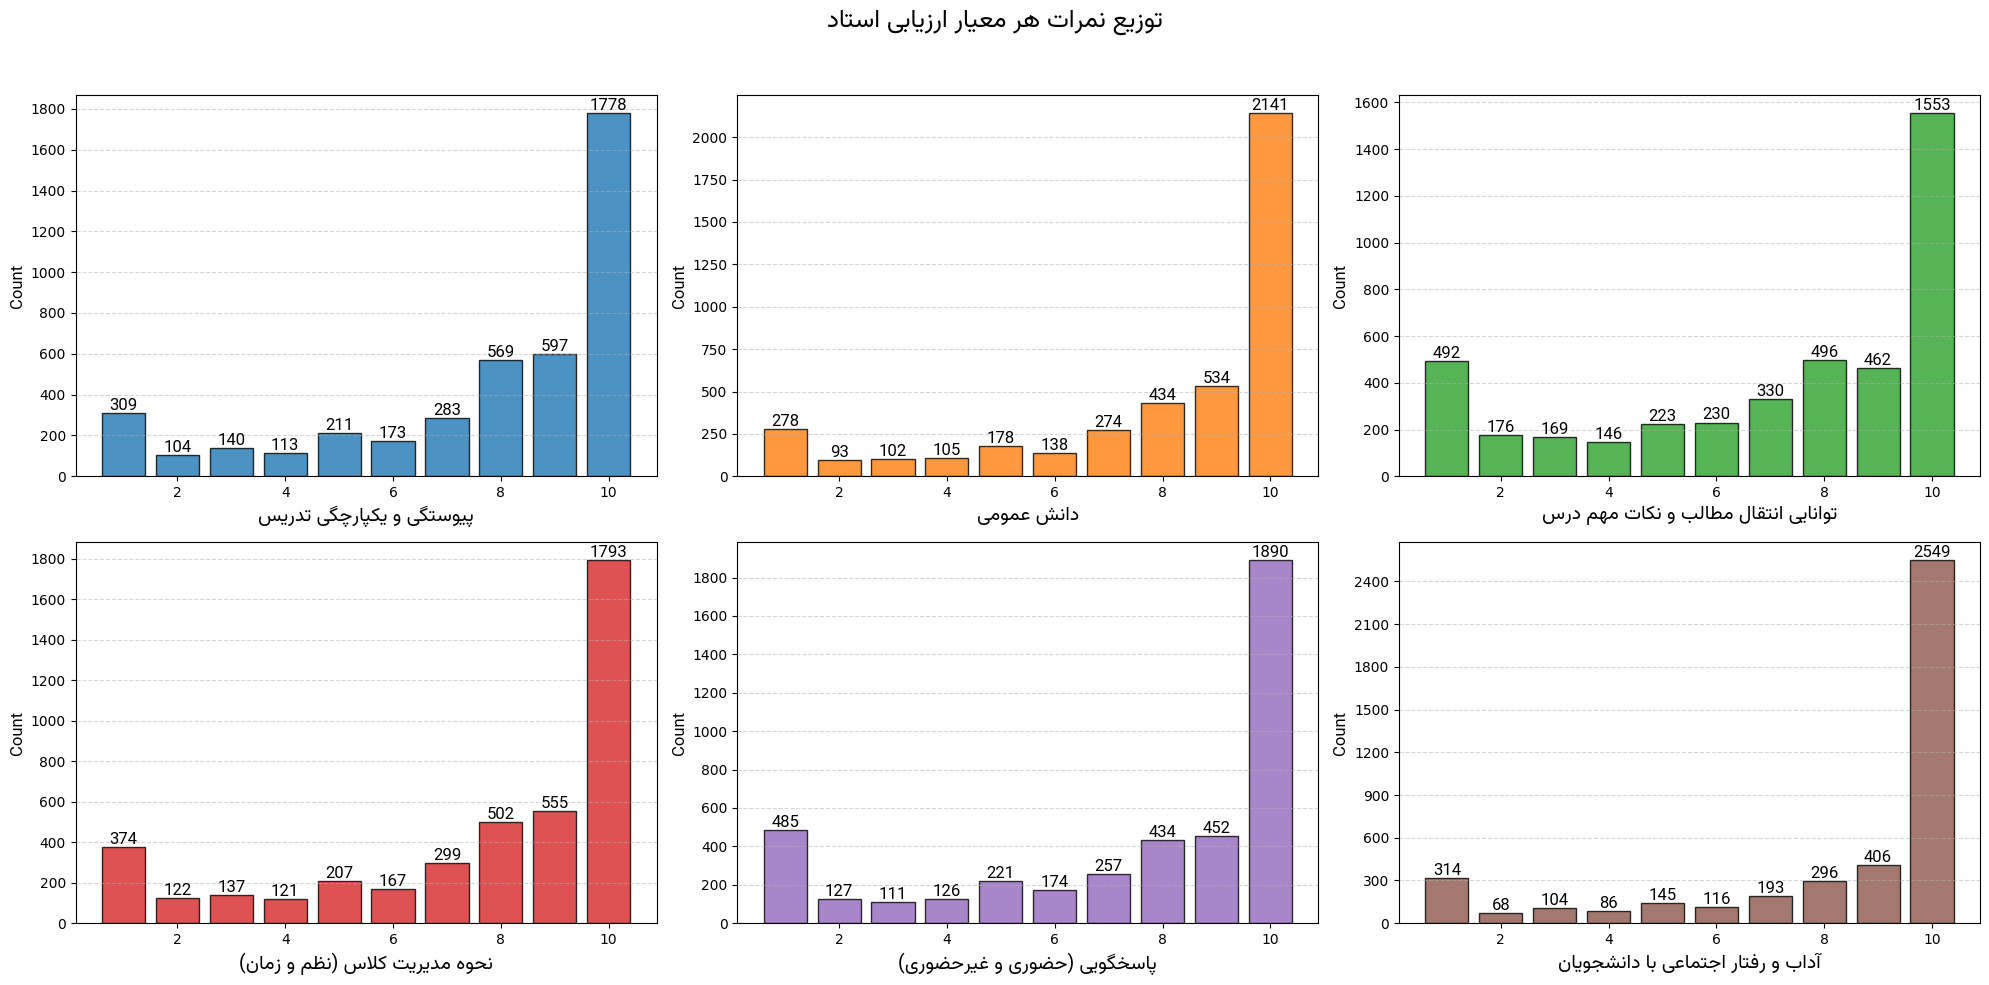

In [27]:
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.ticker import MaxNLocator
import arabic_reshaper
from bidi.algorithm import get_display
from matplotlib import font_manager as fm

# ---------------- Font Setup ----------------
vazir_font_path = "fonts/Vazirmatn-Regular.ttf"
vazir_font = fm.FontProperties(fname=vazir_font_path)

rating_labels = {
    'rating_1': 'پیوستگی و یکپارچگی تدریس',
    'rating_2': 'دانش عمومی',
    'rating_3': 'توانایی انتقال مطالب و نکات مهم درس',
    'rating_4': 'نحوه مدیریت کلاس (نظم و زمان)',
    'rating_5': 'پاسخگویی (حضوری و غیرحضوری)',
    'rating_6': 'آداب و رفتار اجتماعی با دانشجویان'
}

ratings = list(rating_labels.keys())
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

fig, axes = plt.subplots(2, 3, figsize=(20, 10))
axes = axes.flatten()

for i, col in enumerate(ratings):
    ax = axes[i]
    counts = df_parsed[col].value_counts().sort_index()
    bars = ax.bar(counts.index, counts.values, color=colors[i], edgecolor='black', alpha=0.8)
    
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height + 0.1, str(int(height)),
                ha='center', va='bottom', fontsize=12, fontweight='bold', fontproperties=vazir_font)
    
    label_fa = get_display(arabic_reshaper.reshape(rating_labels[col]))
    ax.set_xlabel(label_fa, fontsize=14, fontweight='bold', fontproperties=vazir_font)
    ax.set_ylabel("Count", fontsize=12, fontproperties=vazir_font)
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.grid(axis='y', linestyle='--', alpha=0.5)

fig.suptitle(get_display(arabic_reshaper.reshape("توزیع نمرات هر معیار ارزیابی استاد")),
             fontsize=18, fontweight='bold', fontproperties=vazir_font)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


### What this code does

This code **cleans, normalizes, and standardizes professor and course information** to make the dataset consistent and ready for analysis.

**Main steps:**

1. **Text normalization**
   - Unifies Persian/Arabic characters (`ي → ی`, `ك → ک`)
   - Converts Persian and Arabic digits to English digits
   - Removes extra spaces, punctuation, and lowercases text  
   This reduces spelling and formatting variations.

2. **Professor name unification (Fuzzy Matching)**
   - Normalizes professor names
   - Uses **fuzzy string matching** (`token_set_ratio`) to detect similar names
   - Assigns a unique `id_professor` to the same professor even if written differently

3. **Course name normalization**
   - Creates a cleaned version of course names (`course_name_norm`) for reliable grouping and filtering

4. **Standardizing grading and attendance**
   - Maps free-text descriptions to fixed categories:
     - **Grading:** آسان / منصفانه / سختگیر / نامشخص
     - **Attendance:** آزاد / متوسط / سختگیر / نامشخص

5. **Final output**
   - The DataFrame now includes:
     - `id_professor` (consistent professor identifier)
     - Normalized professor and course names
     - Standardized grading and attendance labels

✅ Result: a **clean, structured dataset** suitable for dashboards, comparisons, and statistical analysis.


In [29]:
import pandas as pd
import re
from fuzzywuzzy import fuzz, process

df = df_parsed.copy()

def normalize_name(name):
    if not isinstance(name, str):
        return ""
    name = name.strip()                    
    name = re.sub(r"\s+", " ", name)     
    name = name.replace("ي", "ی")          
    name = name.replace("ك", "ک")        
    name = name.lower()                   
    name = re.sub(r"[^\w\s]", "", name)   
    return name

df["professor_name_norm"] = df["professor_name_raw"].apply(normalize_name)
unique_names = df["professor_name_norm"].dropna().unique().tolist()

THRESHOLD = 85

professor_id_map = {}  # name_norm -> id_professor
professor_counter = 1

for name in unique_names:
    matched = None
    for existing in professor_id_map:
        if fuzz.token_set_ratio(name, existing) >= THRESHOLD:
            matched = existing
            break
    if matched:
        professor_id_map[name] = professor_id_map[matched]
    else:
        professor_id_map[name] = professor_counter
        professor_counter += 1
        
df["id_professor"] = df["professor_name_norm"].map(professor_id_map)

import re
from fuzzywuzzy import fuzz

def normalize_numbers(text):
    if not isinstance(text, str):
        return ""
    persian_nums = "۰۱۲۳۴۵۶۷۸۹"
    arabic_nums = "٠١٢٣٤٥٦٧٨٩"
    for i, n in enumerate(persian_nums):
        text = text.replace(n, str(i))
    for i, n in enumerate(arabic_nums):
        text = text.replace(n, str(i))
    return text
def normalize_text(text):
    if not isinstance(text, str):
        return ""
    text = text.strip()
    text = re.sub(r"\s+", " ", text)      
    text = text.replace("ي", "ی").replace("ك", "ک")  
    text = normalize_numbers(text)
    text = re.sub(r"[^\w\s]", "", text)
    return text.lower()


def create_professor_id(df, name_col="professor_name_raw", threshold=85):
    df["professor_name_norm"] = df[name_col].apply(normalize_text)
    unique_names = df["professor_name_norm"].dropna().unique()
    
    professor_id_map = {}
    counter = 1
    for name in unique_names:
        matched = None
        for existing in professor_id_map:
            if fuzz.token_set_ratio(name, existing) >= threshold:
                matched = existing
                break
        if matched:
            professor_id_map[name] = professor_id_map[matched]
        else:
            professor_id_map[name] = counter
            counter += 1
    df["id_professor"] = df["professor_name_norm"].map(professor_id_map)
    return df

def normalize_course(df, course_col="course_name"):
    df["course_name_norm"] = df[course_col].apply(normalize_text)
    return df

def map_grading_status(text):
    text = normalize_text(text)
    if any(k in text for k in ["آسان", "راحت", "easy", "خوب"]):
        return "آسان"
    elif any(k in text for k in ["منصف", "fair"]):
        return "منصفانه"
    elif any(k in text for k in ["سخت", "سختگیر", "hard"]):
        return "سختگیر"
    else:
        return "نامشخص"

def map_attendance_status(text):
    text = normalize_text(text)
    if any(k in text for k in ["سخت", "سختگیر", "مهم"]):
        return "سختگیر"
    elif any(k in text for k in ["متوسط", "یادم"]):
        return "متوسط"
    elif any(k in text for k in ["آزاد", "نمی کند"]):
        return "آزاد"
    else:
        return "نامشخص"

def standardize_status(df):
    df["grading_status"] = df["grading_status_raw"].apply(map_grading_status)
    df["attendance_status"] = df["attendance_status_raw"].apply(map_attendance_status)
    return df

df = df_parsed.copy()  

df = create_professor_id(df, "professor_name_raw")

df = normalize_course(df, "course_name")

df = standardize_status(df)

df.head()

,channel_username,message_id,text,date,fetched_at,professor_name_raw,department,course_name,rating_1,rating_2,...,attendance_status_raw,exam_enough_raw,term,comment_text,error_parse,professor_name_norm,id_professor,course_name_norm,grading_status,attendance_status
0,ostad_elmosi,4728,🧑‍🏫 اصغر آب خضر\n🏫 #تربیت_بدنی\n📒 اصغر آب خضر\...,2025-12-11 16:41:18+00:00,2026-02-05 13:29:09.876266+00:00,اصغر آب خضر,تربیت_بدنی,اصغر آب خضر,1.0,1.0,...,یادم نمیاد,خیر,مهر 1401,چیزی اضافه ایی نیست\n~~~~~~~~~~~~~~~~~\nبرای ث...,0,اصغر آب خضر,1,اصغر آب خضر,نامشخص,متوسط
1,ostad_elmosi,4727,🧑‍🏫 فاطمه مهدی زاده سراج\n🏫 #معماری_و_شهرسازی\...,2025-10-10 11:21:44+00:00,2026-02-05 13:29:09.886333+00:00,فاطمه مهدی زاده سراج,معماری_و_شهرسازی,مبانی طراحی ۲,10.0,10.0,...,یادم نمیاد,بله,بهمن ۱۴۰۳,با دکتر طباطبایی و دو سه تا تی ای میان سر کلاس...,0,فاطمه مهدی زاده سراج,2,مبانی طراحی 2,منصفانه,متوسط
2,ostad_elmosi,4726,🧑‍🏫 دکتر بخشایش\n🏫 #مهندسی_مواد\n📒 مواد پیشرفت...,2025-10-10 11:21:31+00:00,2026-02-05 13:29:09.891016+00:00,دکتر بخشایش,مهندسی_مواد,مواد پیشرفته,10.0,10.0,...,حضور مهم است و تاثیر مستقیم دارد,بله,بهمن 1401,استاد مطلعی هستند و اطلاعات به روزی دارند.\n~~...,0,دکتر بخشایش,3,مواد پیشرفته,منصفانه,سختگیر
3,ostad_elmosi,4725,🧑‍🏫 رضا انتظاری ملکی\n🏫 #مهندسی_کامپیوتر\n📒 مب...,2025-10-10 11:21:28+00:00,2026-02-05 13:29:09.896070+00:00,رضا انتظاری ملکی,مهندسی_کامپیوتر,مباحث ویژه نرم افزار ۱,10.0,10.0,...,حضور مهم است و تاثیر مستقیم دارد,بله,بهمن ۱۴۰۳,استاد بسیار خوش اخلاق و محترمی هستند. تعداد تم...,0,رضا انتظاری ملکی,4,مباحث ویژه نرم افزار 1,منصفانه,سختگیر
4,ostad_elmosi,4724,🧑‍🏫 عین الله خنجری\n🏫 #مهندسی_کامپیوتر\n📒 پایگ...,2025-10-10 11:21:17+00:00,2026-02-05 13:29:09.900489+00:00,عین الله خنجری,مهندسی_کامپیوتر,پایگاه داده پیشرفته,8.0,6.0,...,حضور و غیاب نمی کند,بله,بهمن ۱۴۰۳,تو نمره دادن پروژه‌ها بسیار رندوم و بی‌منطق عم...,0,عین الله خنجری,5,پایگاه داده پیشرفته,آسان,آزاد


### Sentiment Analysis Pipeline

This code performs **sentiment analysis on Persian comments** using a pretrained BERT model.

**Main steps:**

1. **Text Preprocessing**
   - Normalizes Persian text using `hazm.Normalizer`.
   - Tokenizes text and removes Persian stopwords.
   - Produces a cleaned version of each comment (`text_clean`).

2. **Model Loading (Once)**
   - Loads the pretrained model  
     **`HooshvareLab/bert-fa-base-uncased-sentiment-snappfood`**.
   - Applies **dynamic quantization** to reduce memory usage and speed up inference on CPU.
   - Sets the model to evaluation mode.

3. **Batch Sentiment Prediction**
   - Processes texts in batches for efficiency.
   - Computes class probabilities using softmax.
   - Assigns labels:
     - `positive` or `negative` if confidence ≥ threshold
     - `neutral` if confidence < threshold
   - Returns both the predicted label and confidence score.

4. **Applying to the DataFrame**
   - Cleans all comments with a progress bar.
   - Predicts sentiment for all rows.
   - Adds results as:
     - `label_sentiment` (positive / negative / neutral)
     - `score_sentiment` (model confidence)

**Result:**  
Each comment in the DataFrame is enriched with a reliable sentiment label and confidence score, ready for analysis or dashboard visualization.


In [ ]:
import pandas as pd
from hazm import Normalizer, word_tokenize, stopwords_list
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from tqdm import tqdm

tqdm.pandas(ncols=80, bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt}')

normalizer = Normalizer()
stopwords = set(stopwords_list())

def preprocess(text):
    text = normalizer.normalize(str(text))
    tokens = word_tokenize(text)
    tokens = [t for t in tokens if t not in stopwords]
    return " ".join(tokens)

if 'model' not in globals():
    model_name = "HooshvareLab/bert-fa-base-uncased-sentiment-snappfood"
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name)

    model = torch.quantization.quantize_dynamic(
        model, {torch.nn.Linear}, dtype=torch.qint8
    )

    device = torch.device("cpu")
    model.to(device)
    model.eval()
    print("✅ Model Loaded with Quantization!")

def predict_sentiment(texts, batch_size=64, confidence_threshold=0.6):
    all_labels = []
    all_scores = []
    labels_map = ["positive", "negative"]

    for i in tqdm(range(0, len(texts), batch_size), ncols=80, desc="Predicting Sentiment"):
        batch_texts = texts[i:i+batch_size]

        inputs = tokenizer(batch_texts, return_tensors="pt", truncation=True, padding=True, max_length=128)
        inputs = {k: v.to(device) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = model(**inputs)

        probs = torch.softmax(outputs.logits, dim=1)
        preds_idx = torch.argmax(probs, dim=1)

        for j, idx in enumerate(preds_idx):
            score = probs[j, idx].item()
            if score < confidence_threshold:
                all_labels.append("neutral")
            else:
                all_labels.append(labels_map[idx])
            all_scores.append(score)

    return all_labels, all_scores

df["text_clean"] = df["comment_text"].fillna("").astype(str).progress_apply(preprocess)

pred_labels, pred_scores = predict_sentiment(
    df["text_clean"].tolist(),
    batch_size=64,
    confidence_threshold=0.85
)

df["label_sentiment"] = pred_labels
df["score_sentiment"] = pred_scores

df.head()


### 📊 Quick Data Exploration

This cell performs a basic exploratory analysis of the DataFrame:

- **Displays the first 5 rows** to get an initial look at the data structure.
- **Shows DataFrame information** (column names, data types, and missing values).
- **Generates descriptive statistics** (count, mean, std, min, max) for numerical columns.
- **Counts samples per sentiment class** using the `label_sentiment` column.
- **Computes the average sentiment score** (`score_sentiment`) for each sentiment class.
- **Displays 5 random samples** to inspect data variability and quality.


In [81]:
print("📄 First 5 rows:")
display(df.head(5))

print("\nℹ️ DataFrame information:")
print(df.info())

print("\n📊 Summary:")
display(df.describe())

print("\n🧮 Count per class:")
display(df['label_sentiment'].value_counts())

print("\n📈 Average score_sentiment per class:")
display(df.groupby('label_sentiment')['score_sentiment'].mean())

print("\n🎲 5 Random:")
display(df.sample(5))


📄 First 5 rows:


,channel_username,message_id,text,date,fetched_at,professor_name_raw,department,course_name,rating_1,rating_2,...,score_sentiment,topic,cluster,pca1,pca2,similarity,mean_rating,rule_score,hybrid_score,recommend_score
0,ostad_elmosi,4728,🧑‍🏫 اصغر آب خضر\n🏫 #تربیت_بدنی\n📒 اصغر آب خضر\...,2025-12-11 16:41:18+00:00,2026-02-05 13:29:09.876266+00:00,اصغر آب خضر,تربیت_بدنی,اصغر آب خضر,1.0,1.0,...,0.978934,1,1,-5.670873,0.049225,1.000000,0.996991,0,0.522883,2.099699
1,ostad_elmosi,4727,🧑‍🏫 فاطمه مهدی زاده سراج\n🏫 #معماری_و_شهرسازی\...,2025-10-10 11:21:44+00:00,2026-02-05 13:29:09.886333+00:00,فاطمه مهدی زاده سراج,معماری_و_شهرسازی,مبانی طراحی ۲,10.0,10.0,...,0.621054,0,0,2.171596,-1.943389,-0.733438,8.660151,2,0.032050,2.866015
2,ostad_elmosi,4726,🧑‍🏫 دکتر بخشایش\n🏫 #مهندسی_مواد\n📒 مواد پیشرفت...,2025-10-10 11:21:31+00:00,2026-02-05 13:29:09.891016+00:00,دکتر بخشایش,مهندسی_مواد,مواد پیشرفته,10.0,10.0,...,0.837094,-1,2,2.010616,-0.280860,-0.969501,8.691013,2,-0.085273,2.869101
3,ostad_elmosi,4725,🧑‍🏫 رضا انتظاری ملکی\n🏫 #مهندسی_کامپیوتر\n📒 مب...,2025-10-10 11:21:28+00:00,2026-02-05 13:29:09.896070+00:00,رضا انتظاری ملکی,مهندسی_کامپیوتر,مباحث ویژه نرم افزار ۱,10.0,10.0,...,0.851727,-1,2,1.998289,-0.166037,-0.974213,8.693104,2,-0.087581,2.869310
4,ostad_elmosi,4724,🧑‍🏫 عین الله خنجری\n🏫 #مهندسی_کامپیوتر\n📒 پایگ...,2025-10-10 11:21:17+00:00,2026-02-05 13:29:09.900489+00:00,عین الله خنجری,مهندسی_کامپیوتر,پایگاه داده پیشرفته,8.0,6.0,...,0.749617,4,1,-2.520896,-1.348313,0.704715,4.107088,1,0.546624,2.410709



ℹ️ DataFrame information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4557 entries, 0 to 4556
Data columns (total 37 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   channel_username       4557 non-null   object             
 1   message_id             4557 non-null   int64              
 2   text                   4557 non-null   object             
 3   date                   4557 non-null   datetime64[ns, UTC]
 4   fetched_at             4557 non-null   datetime64[ns, UTC]
 5   professor_name_raw     4557 non-null   object             
 6   department             4557 non-null   object             
 7   course_name            4557 non-null   object             
 8   rating_1               4557 non-null   float64            
 9   rating_2               4557 non-null   float64            
 10  rating_3               4557 non-null   float64            
 11  rating_4               4557 n

,message_id,rating_1,rating_2,rating_3,rating_4,rating_5,rating_6,error_parse,id_professor,score_sentiment,topic,cluster,pca1,pca2,similarity,mean_rating,rule_score,hybrid_score,recommend_score
count,4557.000000,4557.000000,4557.000000,4557.000000,4557.000000,4557.000000,4557.000000,4557.0,4557.000000,4557.000000,4557.000000,4557.000000,4.557000e+03,4.557000e+03,4557.000000,4557.000000,4557.000000,4557.000000,4557.000000
mean,2401.520518,7.754968,8.069675,7.106851,7.618424,7.473463,8.274491,0.0,238.424183,0.894998,-0.141979,1.428791,-1.609129e-15,-1.376024e-16,-0.210042,6.741839,1.141102,0.163829,2.674184
std,1361.544722,2.752571,2.679272,3.090818,2.888522,3.068441,2.733870,0.0,184.602254,0.126456,1.178079,0.763544,2.155363e+00,9.805075e-01,0.678175,2.122219,0.876013,0.248789,0.212222
min,12.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,0.500302,-1.000000,0.000000,-5.900910e+00,-3.733342e+00,-0.978520,0.928615,0.000000,-0.201394,2.092861
25%,1230.000000,7.000000,7.000000,5.000000,7.000000,6.000000,8.000000,0.0,75.000000,0.859343,-1.000000,1.000000,-1.005493e+00,-2.562964e-01,-0.854715,5.839256,0.000000,-0.042981,2.583926
50%,2420.000000,9.000000,9.000000,8.000000,9.000000,9.000000,10.000000,0.0,191.000000,0.956749,-1.000000,2.000000,7.112730e-01,3.279645e-01,-0.442845,7.425294,1.000000,0.097897,2.742529
75%,3580.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,0.0,368.000000,0.980853,0.000000,2.000000,1.750288e+00,6.998975e-01,0.422685,8.426879,2.000000,0.394272,2.842688
max,4728.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,0.0,706.000000,0.998147,7.000000,2.000000,2.303274e+00,1.053336e+00,1.000000,8.713786,3.000000,0.765913,2.871379



🧮 Count per class:


label_sentiment
negative    2465
neutral     1068
positive    1024
Name: count, dtype: int64


📈 Average score_sentiment per class:


label_sentiment
negative    0.964979
neutral     0.694105
positive    0.936063
Name: score_sentiment, dtype: float64


🎲 5 Random:


,channel_username,message_id,text,date,fetched_at,professor_name_raw,department,course_name,rating_1,rating_2,...,score_sentiment,topic,cluster,pca1,pca2,similarity,mean_rating,rule_score,hybrid_score,recommend_score
816,ostad_elmosi,3908,🧑‍🏫 مرضیه ملکی مجد\n🏫 #مهندسی_کامپیوتر\n📒 طراح...,2024-07-19 14:18:06+00:00,2026-02-05 13:29:17.240053+00:00,مرضیه ملکی مجد,مهندسی_کامپیوتر,طراحی الگوریتم,10.0,10.0,...,0.526574,-1,0,2.137254,-2.732502,-0.615594,8.503796,2,0.087383,2.850380
1622,ostad_elmosi,3093,🧑‍🏫 محمد عظیم کرمی\n🏫 #برق\n📒 مدار منطقی\n\nمن...,2024-02-02 15:08:46+00:00,2026-02-05 13:29:25.823078+00:00,محمد عظیم کرمی,برق,مدار منطقی,8.0,5.0,...,0.995545,-1,2,-0.146308,0.771764,0.148362,6.713649,2,0.428273,2.671365
4032,ostad_elmosi,560,🧑‍🏫 رضا سعادتی\n🏫 #ریاضی\n📒 ریاضی ۱\n\nمنابع آ...,2022-01-27 21:29:51+00:00,2026-02-05 13:29:58.682975+00:00,رضا سعادتی,ریاضی,ریاضی ۱,10.0,10.0,...,0.978972,1,2,1.870469,0.925312,-0.881003,8.711282,2,-0.040559,2.871128
378,ostad_elmosi,4348,🧑‍🏫 امیرمحمود بخشایش\n🏫 #مهندسی_مواد\n📒 اقتصاد...,2025-02-12 18:58:09+00:00,2026-02-05 13:29:12.873502+00:00,امیرمحمود بخشایش,مهندسی_مواد,اقتصاد,7.0,8.0,...,0.834609,-1,2,-1.064928,-0.565634,0.493732,5.690658,0,0.377479,2.569066
3331,ostad_elmosi,1317,🧑‍🏫 شاه علی\n🏫 #معارف\n📒 انقلاب اسلامی\n\nمناب...,2023-01-12 12:01:34+00:00,2026-02-05 13:29:49.493524+00:00,شاه علی,معارف,انقلاب اسلامی,10.0,10.0,...,0.827056,-1,2,2.029383,-0.308406,-0.964580,8.689579,1,-0.182846,2.868958


### Topic Modeling with BERTopic

This cell applies **BERTopic** to discover main topics in cleaned text comments (`df['text_clean']`).

- A custom `TqdmIterable` wrapper is used to show a **progress bar** while processing texts.
- `CountVectorizer` (with a maximum of 2000 features) converts text into numerical representations.
- A **multilingual BERTopic model** is created and fitted to the text data.
- The model assigns a **topic ID** to each comment, which is added to the DataFrame as `df['topic']`.
- Finally, the code prints the **top keywords of each discovered topic**, excluding outliers (`topic = -1`).

Overall, this cell performs unsupervised topic modeling and helps identify common themes in user comments.


In [47]:
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
from tqdm import tqdm

# =========================
# Assuming df['text_clean'] is ready
# =========================

# Wrap texts in tqdm for a progress bar during iteration
class TqdmIterable(list):
    def __iter__(self):
        return iter(tqdm(super().__iter__(), desc="Processing comments", ncols=100))

texts_with_progress = TqdmIterable(df['text_clean'].tolist())

# Create BERTopic model
vectorizer_model = CountVectorizer(max_features=2000)
topic_model = BERTopic(vectorizer_model=vectorizer_model, language="multilingual",verbose=True)

# Fit model with progress bar
print("Fitting BERTopic model...")
topics, probs = topic_model.fit_transform(texts_with_progress)

# Add topic labels to df
df['topic'] = topics

# Show progress while printing main topics
print("\nTop topics found by BERTopic:")
for topic_num in tqdm(set(topics), desc="Listing topics", ncols=100):
    if topic_num == -1:
        continue  # -1 = outliers
    topic_terms = topic_model.get_topic(topic_num)
    print(f"Topic {topic_num}: {topic_terms}")


Fitting BERTopic model...


Processing comments: 4557it [00:00, 2333468.85it/s]
Processing comments: 4557it [00:00, 3232991.09it/s]
2026-02-05 18:17:42,927 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/143 [00:00<?, ?it/s]

2026-02-05 18:19:43,012 - BERTopic - Embedding - Completed ✓
2026-02-05 18:19:43,013 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2026-02-05 18:19:43,094 - BERTopic - Dimensionality - Completed ✓
2026-02-05 18:19:43,096 - BERTopic - Cluster - Start clustering the reduced embeddings
2026-02-05 18:19:43,354 - BERTopic - Cluster - Completed ✓
2026-02-05 18:19:43,359 - BERTopic - Representation - Fine-tuning topics using representation models.
2026-02-05 18:19:43,511 - BERTopic - Representation - Completed ✓



Top topics found by BERTopic:


Listing topics: 100%|███████████████████████████████████████████████| 9/9 [00:00<00:00, 5365.85it/s]

Topic 0: [('معرفی', np.float64(0.051944475473385425)), ('ostad_elmosi', np.float64(0.05134756555743922)), ('استاد', np.float64(0.050991998595460906)), ('نمره', np.float64(0.04957029957923278)), ('بدید', np.float64(0.03828533968676989)), ('اساتید', np.float64(0.03807451991304575)), ('دانشگاه', np.float64(0.03744330449324289)), ('علم', np.float64(0.03727747135578071)), ('ثبت', np.float64(0.03720707255740546)), ('صنعت', np.float64(0.03720256479468397))]
Topic 1: [('ایی', np.float64(0.2035225978128534)), ('اضافه', np.float64(0.1858695573538616)), ('ostad_elmosi', np.float64(0.1396623532878255)), ('معرفی', np.float64(0.13814156784668039)), ('ostad_elmosibot', np.float64(0.10086801893778338)), ('ربات', np.float64(0.1008454591536844)), ('پیام', np.float64(0.10077785442724418)), ('صنعت', np.float64(0.10065420227668925)), ('کانال', np.float64(0.1006317602450317)), ('علم', np.float64(0.1005533101772825))]
Topic 2: [('', 1e-05), ('', 1e-05), ('', 1e-05), ('', 1e-05), ('', 1e-05), ('', 1e-05), (''

In [48]:
total_rows = len(df)

valid_topics = [t for t in df['topic'].unique() if t != -1]

report = []

for topic_num in valid_topics:
    topic_df = df[df['topic'] == topic_num]
    count = len(topic_df)
    percentage = (count / total_rows) * 100
    samples = topic_df['text_clean'].head(3).tolist()
    report.append({
        "Topic": topic_num,
        "Count": count,
        "Percentage": round(percentage, 2),
        "Sample Texts": samples,
        "Top Terms": topic_model.get_topic(topic_num)
    })

report_df = pd.DataFrame(report).sort_values(by="Count", ascending=False)

display(report_df)

df.head()


,Topic,Count,Percentage,Sample Texts,Top Terms
1,0,1318,28.92,[دکتر طباطبایی تی‌ای سر کلاس خوبه کلاساش استفا...,"[(معرفی, 0.051944475473385425), (ostad_elmosi,..."
0,1,567,12.44,[اضافه ایی ~~~~~~~~~~~~~~~~~ ثبت معرفی استاد ر...,"[(ایی, 0.2035225978128534), (اضافه, 0.18586955..."
5,2,252,5.53,"[, , ]","[(, 1e-05), (, 1e-05), (, 1e-05), (, 1e-05), (..."
4,3,49,1.08,[اضافه ایی ~~~~~~~~~~~~~~~~~ ثبت معرفی استاد ر...,"[(ایی, 0.2035225978128534), (اضافه, 0.18586955..."
2,4,48,1.05,[نمره پروژه‌ها رندوم بی‌منطق عمل میکنه نمره پر...,"[(ostad_elmosi, 0.14353209103635467), (معرفی, ..."
7,5,17,0.37,"[, , ]","[(, 1e-05), (, 1e-05), (, 1e-05), (, 1e-05), (..."
6,6,12,0.26,"[, , ]","[(, 1e-05), (, 1e-05), (, 1e-05), (, 1e-05), (..."
3,7,10,0.22,[ایشون ندارید اصلا توصیه نمیشه بدترین نمره پیش...,"[(نمره, 0.07894722066966632), (هست, 0.03892866..."


,channel_username,message_id,text,date,fetched_at,professor_name_raw,department,course_name,rating_1,rating_2,...,error_parse,professor_name_norm,id_professor,course_name_norm,grading_status,attendance_status,text_clean,label_sentiment,score_sentiment,topic
0,ostad_elmosi,4728,🧑‍🏫 اصغر آب خضر\n🏫 #تربیت_بدنی\n📒 اصغر آب خضر\...,2025-12-11 16:41:18+00:00,2026-02-05 13:29:09.876266+00:00,اصغر آب خضر,تربیت_بدنی,اصغر آب خضر,1.0,1.0,...,0,اصغر آب خضر,1,اصغر آب خضر,نامشخص,متوسط,اضافه ایی ~~~~~~~~~~~~~~~~~ ثبت معرفی استاد رب...,negative,0.978934,1
1,ostad_elmosi,4727,🧑‍🏫 فاطمه مهدی زاده سراج\n🏫 #معماری_و_شهرسازی\...,2025-10-10 11:21:44+00:00,2026-02-05 13:29:09.886333+00:00,فاطمه مهدی زاده سراج,معماری_و_شهرسازی,مبانی طراحی ۲,10.0,10.0,...,0,فاطمه مهدی زاده سراج,2,مبانی طراحی 2,منصفانه,متوسط,دکتر طباطبایی تی‌ای سر کلاس خوبه کلاساش استفاد...,neutral,0.621054,0
2,ostad_elmosi,4726,🧑‍🏫 دکتر بخشایش\n🏫 #مهندسی_مواد\n📒 مواد پیشرفت...,2025-10-10 11:21:31+00:00,2026-02-05 13:29:09.891016+00:00,دکتر بخشایش,مهندسی_مواد,مواد پیشرفته,10.0,10.0,...,0,دکتر بخشایش,3,مواد پیشرفته,منصفانه,سختگیر,استاد مطلعی اطلاعات روزی . ~~~~~~~~~~~~~~~~~ ث...,neutral,0.837094,-1
3,ostad_elmosi,4725,🧑‍🏫 رضا انتظاری ملکی\n🏫 #مهندسی_کامپیوتر\n📒 مب...,2025-10-10 11:21:28+00:00,2026-02-05 13:29:09.896070+00:00,رضا انتظاری ملکی,مهندسی_کامپیوتر,مباحث ویژه نرم افزار ۱,10.0,10.0,...,0,رضا انتظاری ملکی,4,مباحث ویژه نرم افزار 1,منصفانه,سختگیر,استاد خوش‌اخلاق محترمی . تمرین‌های درسشون زیاد...,positive,0.851727,-1
4,ostad_elmosi,4724,🧑‍🏫 عین الله خنجری\n🏫 #مهندسی_کامپیوتر\n📒 پایگ...,2025-10-10 11:21:17+00:00,2026-02-05 13:29:09.900489+00:00,عین الله خنجری,مهندسی_کامپیوتر,پایگاه داده پیشرفته,8.0,6.0,...,0,عین الله خنجری,5,پایگاه داده پیشرفته,آسان,آزاد,نمره پروژه‌ها رندوم بی‌منطق عمل میکنه نمره پرو...,neutral,0.749617,4


### TF‑IDF Keywords & Word Cloud Visualization

This notebook computes **TF‑IDF scores** on preprocessed Persian texts (`text_clean`) to identify the most important keywords.

- **Global TF‑IDF**:  
  TF‑IDF is calculated for the entire dataset, and the mean score of each word is used to rank keywords by overall importance.

- **Dataset Word Cloud**:  
  A word cloud is generated using TF‑IDF weights, providing a visual summary of dominant terms across all texts (with proper Persian font rendering).

- **Topic‑level Word Clouds**:  
  If a `topic` column exists (e.g., from BERTopic), a separate word cloud is created for each topic (excluding outliers), highlighting topic‑specific vocabulary.

This approach combines **quantitative keyword ranking** with **intuitive visual exploration** of themes in Persian text data.

Top 20 keywords for the whole dataset:


معرفی              0.129527
ostad_elmosi       0.128251
استاد              0.088609
نمره               0.069232
ایی                0.066055
بدید               0.065547
اساتید             0.065434
اضافه              0.064799
دانشگاه            0.064782
ثبت                0.064496
علم                0.064387
صنعت               0.064316
کانال              0.064278
پیام               0.064181
ربات               0.064140
ostad_elmosibot    0.064126
ترم                0.037364
کلاس               0.034826
درس                0.029340
می                 0.026894
dtype: float64

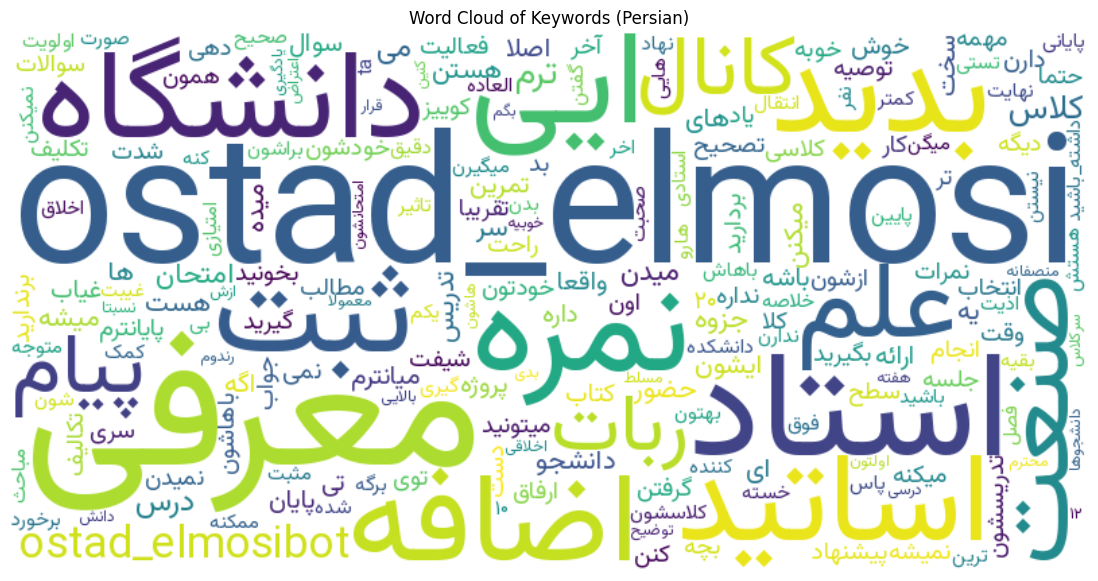

Generating topic WordClouds:   0%|                                            | 0/8 [00:00<?, ?it/s]

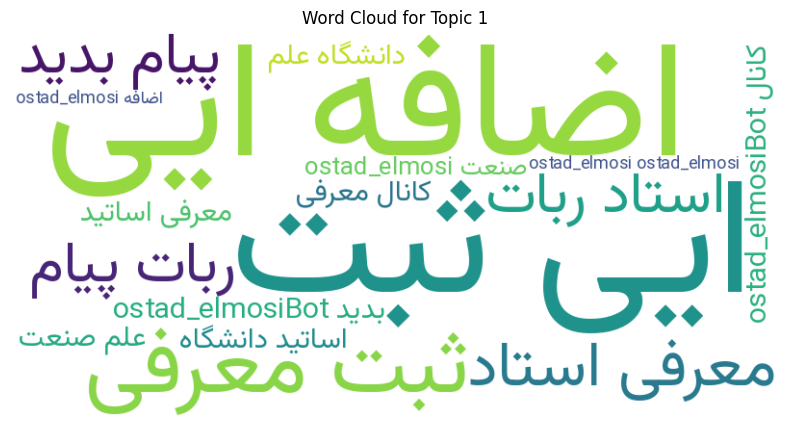

Generating topic WordClouds:  12%|████▌                               | 1/8 [00:00<00:05,  1.27it/s]

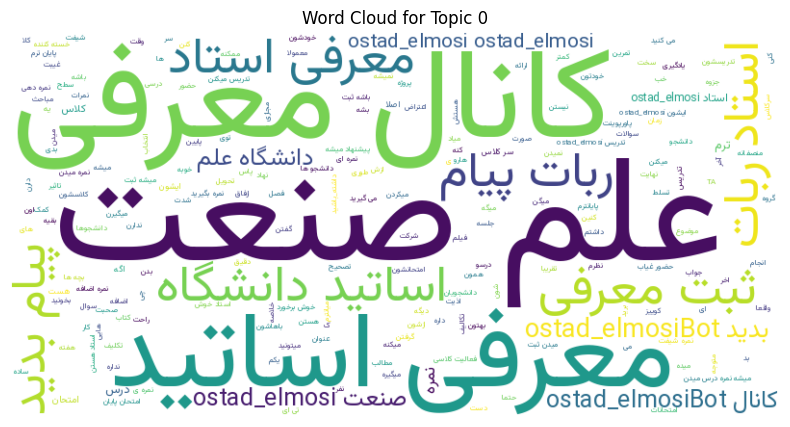

Generating topic WordClouds:  25%|█████████                           | 2/8 [00:02<00:08,  1.36s/it]

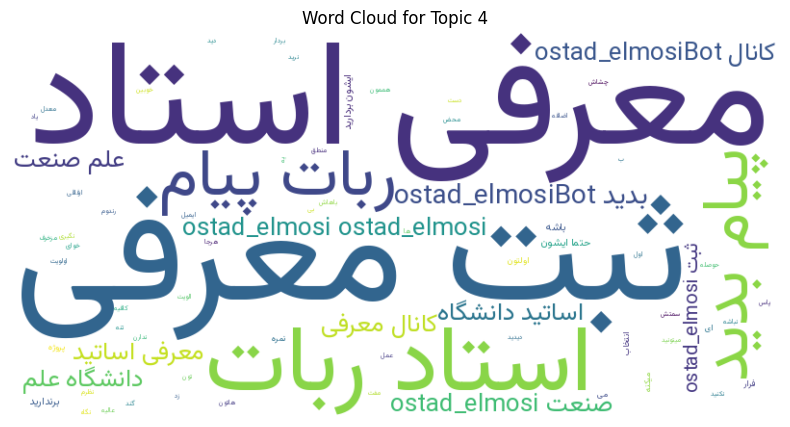

Generating topic WordClouds:  38%|█████████████▌                      | 3/8 [00:03<00:06,  1.20s/it]

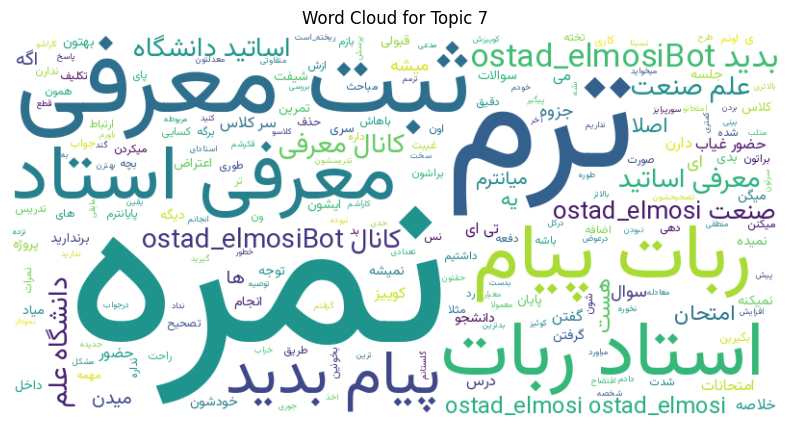

Generating topic WordClouds:  50%|██████████████████                  | 4/8 [00:04<00:04,  1.18s/it]

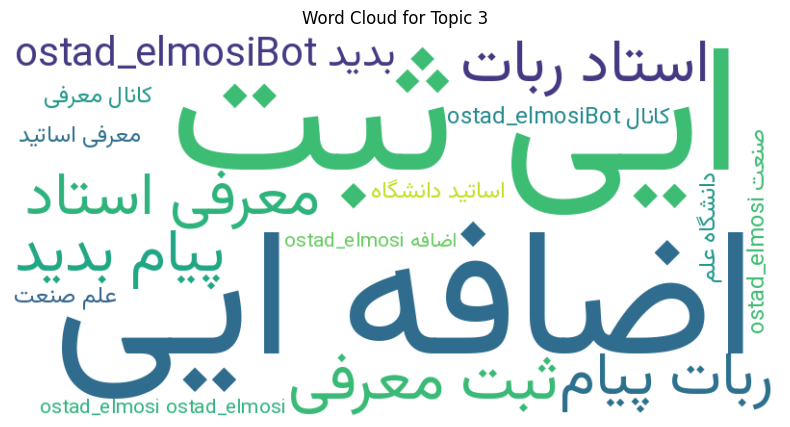

Generating topic WordClouds: 100%|████████████████████████████████████| 8/8 [00:05<00:00,  1.44it/s]


In [54]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import display
import numpy as np

# =========================
# 1. TF-IDF for whole dataset
# =========================
vectorizer = TfidfVectorizer(max_features=2000, stop_words=None)  # texts already preprocessed
tfidf_matrix = vectorizer.fit_transform(df['text_clean'])

# Compute mean TF-IDF per word without converting to DataFrame
tfidf_mean = np.array(tfidf_matrix.mean(axis=0)).flatten()
feature_names = vectorizer.get_feature_names_out()
tfidf_series = pd.Series(tfidf_mean, index=feature_names).sort_values(ascending=False)

print("Top 20 keywords for the whole dataset:")
display(tfidf_series.head(20))

# =========================
# 2. WordCloud for the whole dataset
# =========================
wordcloud = WordCloud(
    font_path="fonts/Vazirmatn-Regular.ttf",  # Persian font
    width=800,
    height=400,
    background_color='white'
).generate_from_frequencies(tfidf_series.to_dict())

plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Keywords (Persian)")
plt.show()

# =========================
# 3. WordCloud per topic (fast method)
# =========================
if 'topic' in df.columns:
    topics = [t for t in df['topic'].unique() if t != -1]  # skip outliers
    for topic_num in tqdm(topics, desc="Generating topic WordClouds", ncols=100):
        topic_texts = df[df['topic'] == topic_num]['text_clean']
        if len(topic_texts) == 0:
            continue
        
        # join all texts in this topic
        topic_text_str = " ".join(topic_texts).strip()
        
        if not topic_text_str:  # skip if text is empty
            continue
        
        wc = WordCloud(
            font_path="fonts/Vazirmatn-Regular.ttf",
            width=800,
            height=400,
            background_color='white'
        ).generate(topic_text_str)
        
        plt.figure(figsize=(12, 5))
        plt.imshow(wc, interpolation='bilinear')
        plt.axis('off')
        plt.title(f"Word Cloud for Topic {topic_num}")
        plt.show()



In [55]:
df.head()

,channel_username,message_id,text,date,fetched_at,professor_name_raw,department,course_name,rating_1,rating_2,...,error_parse,professor_name_norm,id_professor,course_name_norm,grading_status,attendance_status,text_clean,label_sentiment,score_sentiment,topic
0,ostad_elmosi,4728,🧑‍🏫 اصغر آب خضر\n🏫 #تربیت_بدنی\n📒 اصغر آب خضر\...,2025-12-11 16:41:18+00:00,2026-02-05 13:29:09.876266+00:00,اصغر آب خضر,تربیت_بدنی,اصغر آب خضر,1.0,1.0,...,0,اصغر آب خضر,1,اصغر آب خضر,نامشخص,متوسط,اضافه ایی ~~~~~~~~~~~~~~~~~ ثبت معرفی استاد رب...,negative,0.978934,1
1,ostad_elmosi,4727,🧑‍🏫 فاطمه مهدی زاده سراج\n🏫 #معماری_و_شهرسازی\...,2025-10-10 11:21:44+00:00,2026-02-05 13:29:09.886333+00:00,فاطمه مهدی زاده سراج,معماری_و_شهرسازی,مبانی طراحی ۲,10.0,10.0,...,0,فاطمه مهدی زاده سراج,2,مبانی طراحی 2,منصفانه,متوسط,دکتر طباطبایی تی‌ای سر کلاس خوبه کلاساش استفاد...,neutral,0.621054,0
2,ostad_elmosi,4726,🧑‍🏫 دکتر بخشایش\n🏫 #مهندسی_مواد\n📒 مواد پیشرفت...,2025-10-10 11:21:31+00:00,2026-02-05 13:29:09.891016+00:00,دکتر بخشایش,مهندسی_مواد,مواد پیشرفته,10.0,10.0,...,0,دکتر بخشایش,3,مواد پیشرفته,منصفانه,سختگیر,استاد مطلعی اطلاعات روزی . ~~~~~~~~~~~~~~~~~ ث...,neutral,0.837094,-1
3,ostad_elmosi,4725,🧑‍🏫 رضا انتظاری ملکی\n🏫 #مهندسی_کامپیوتر\n📒 مب...,2025-10-10 11:21:28+00:00,2026-02-05 13:29:09.896070+00:00,رضا انتظاری ملکی,مهندسی_کامپیوتر,مباحث ویژه نرم افزار ۱,10.0,10.0,...,0,رضا انتظاری ملکی,4,مباحث ویژه نرم افزار 1,منصفانه,سختگیر,استاد خوش‌اخلاق محترمی . تمرین‌های درسشون زیاد...,positive,0.851727,-1
4,ostad_elmosi,4724,🧑‍🏫 عین الله خنجری\n🏫 #مهندسی_کامپیوتر\n📒 پایگ...,2025-10-10 11:21:17+00:00,2026-02-05 13:29:09.900489+00:00,عین الله خنجری,مهندسی_کامپیوتر,پایگاه داده پیشرفته,8.0,6.0,...,0,عین الله خنجری,5,پایگاه داده پیشرفته,آسان,آزاد,نمره پروژه‌ها رندوم بی‌منطق عمل میکنه نمره پرو...,neutral,0.749617,4


### 📌 Model Training & Evaluation

This notebook cell trains and evaluates a **sentiment classification model** using structured professor/course features.

**What the code does:**
- **Selects features**:  
  - Numeric ratings (`rating_1` … `rating_6`, `score_sentiment`)  
  - Categorical variables (`grading_status`, `attendance_status`)  
  - Target label: `label_sentiment`
- **Builds a preprocessing pipeline**:  
  - Standardizes numeric features  
  - One‑hot encodes categorical features
- **Trains a Random Forest classifier** within a unified `Pipeline`.
- **Performs 5‑fold Stratified Cross‑Validation** (with `tqdm` progress bar) and reports:
  - Mean Accuracy  
  - Mean Weighted F1‑Score
- **Retrains the model on the full dataset** for final use.
- **Evaluates performance** using a confusion matrix on the full data.
- **Reports feature importance** for numeric features from the trained Random Forest.

Overall, this cell provides a clean, end‑to‑end workflow for preprocessing, cross‑validated evaluation, final training, and basic model interpretability.


In [57]:
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
from tqdm import tqdm
import numpy as np

# -----------------------------
# 1️⃣ Load DataFrame
# -----------------------------
df = df.copy() 

# -----------------------------
# 2️⃣ Define Features and Target
# -----------------------------
numeric_features = ['rating_1', 'rating_2', 'rating_3', 'rating_4', 'rating_5', 'rating_6', 'score_sentiment']
categorical_features = ['grading_status', 'attendance_status']
target = 'label_sentiment'

X = df[numeric_features + categorical_features]
y = df[target]

# -----------------------------
# 3️⃣ Preprocessing Pipeline
# -----------------------------
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1))
])

# -----------------------------
# 4️⃣ Cross-Validation with tqdm Loading
# -----------------------------
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
accuracies = []
f1_scores = []

print("Starting 5-Fold Cross-Validation...")
for train_index, test_index in tqdm(kf.split(X, y), total=kf.get_n_splits()):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    accuracies.append(accuracy_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred, average='weighted'))

print("\n=== Cross-Validation Results ===")
print(f"Mean Accuracy: {np.mean(accuracies):.4f}")
print(f"Mean F1 Score: {np.mean(f1_scores):.4f}")

# -----------------------------
# 5️⃣ Final Training on full dataset
# -----------------------------
print("\nTraining final model on full dataset...")
model.fit(X, y)
print("Training complete ✅")

# -----------------------------
# 6️⃣ Confusion Matrix (full data)
# -----------------------------
y_pred_full = model.predict(X)
print("\n=== Confusion Matrix (Full Data) ===")
print(confusion_matrix(y, y_pred_full))

# -----------------------------
# 7️⃣ Feature Importance (numeric only)
# -----------------------------
importances = model.named_steps['classifier'].feature_importances_[:len(numeric_features)]
print("\nFeature Importance (numeric features):")
for f, imp in zip(numeric_features, importances):
    print(f"{f}: {imp:.4f}")


Starting 5-Fold Cross-Validation...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.69it/s]



=== Cross-Validation Results ===
Mean Accuracy: 0.8444
Mean F1 Score: 0.8365

Training final model on full dataset...
Training complete ✅

=== Confusion Matrix (Full Data) ===
[[2465    0    0]
 [   0 1068    0]
 [   0    0 1024]]

Feature Importance (numeric features):
rating_1: 0.0456
rating_2: 0.0434
rating_3: 0.0522
rating_4: 0.0513
rating_5: 0.0555
rating_6: 0.0371
score_sentiment: 0.6501


### K-Means Clustering of Teachers

This code performs **unsupervised clustering** on teachers based on their ratings, sentiment score, grading style, and attendance behavior.

**Steps overview:**
1. **Feature selection:**  
   Uses 6 numeric rating scores + sentiment score, and two categorical features (grading and attendance status).

2. **Preprocessing:**  
   - Missing numeric values → filled with the mean and standardized  
   - Missing categorical values → filled with the most frequent value and one‑hot encoded  
   - All preprocessing is handled via a `ColumnTransformer` pipeline.

3. **Clustering (K-Means):**  
   Applies K-Means with `k=3` to group teachers into similar profiles and assigns a cluster label to each row.

4. **Dimensionality reduction (PCA):**  
   Reduces the high‑dimensional data to 2 components for visualization.

5. **Visualization:**  
   Displays a 2D scatter plot of teachers colored by cluster.

6. **Cluster interpretation:**  
   For each cluster, the code prints:
   - Mean ratings and sentiment score  
   - Distribution of grading and attendance styles  
   - A simple rule‑based interpretation (e.g., *Popular & fair*, *Strict & unpopular*, *Moderate*).

**Goal:**  
Identify and visualize distinct teacher profiles based on quantitative ratings, sentiment, and teaching behavior.


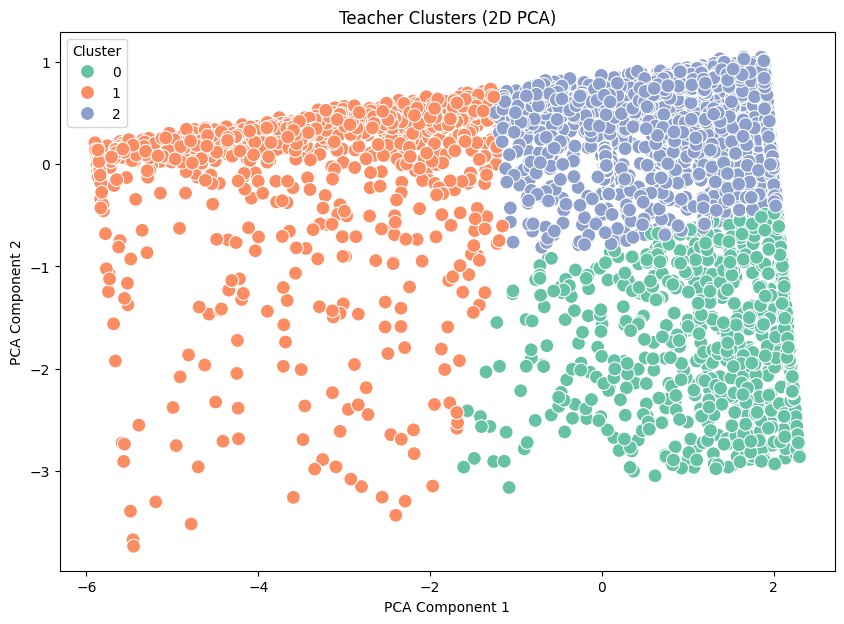


Cluster 0 Summary:
Mean ratings: {'rating_1': 9.03, 'rating_2': 9.31, 'rating_3': 8.6, 'rating_4': 8.98, 'rating_5': 8.87, 'rating_6': 9.44, 'score_sentiment': 0.66}
Mean score_sentiment: 0.66
Grading status counts: {'منصفانه': 400, 'نامشخص': 304, 'آسان': 66}
Attendance status counts: {'سختگیر': 619, 'آزاد': 139, 'متوسط': 12}
Suggested interpretation: Moderate/average

Cluster 1 Summary:
Mean ratings: {'rating_1': 3.96, 'rating_2': 4.4, 'rating_3': 2.72, 'rating_4': 3.74, 'rating_5': 3.34, 'rating_6': 4.77, 'score_sentiment': 0.94}
Mean score_sentiment: 0.94
Grading status counts: {'آسان': 788, 'منصفانه': 162, 'نامشخص': 112, 'سختگیر': 1}
Attendance status counts: {'سختگیر': 721, 'آزاد': 286, 'متوسط': 56}
Suggested interpretation: Moderate/average

Cluster 2 Summary:
Mean ratings: {'rating_1': 9.0, 'rating_2': 9.27, 'rating_3': 8.54, 'rating_4': 8.88, 'rating_5': 8.83, 'rating_6': 9.43, 'score_sentiment': 0.94}
Mean score_sentiment: 0.94
Grading status counts: {'نامشخص': 1268, 'منصفانه

In [62]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# 1️⃣ Load DataFrame
# -----------------------------
df = df.copy()  

# -----------------------------
# 2️⃣ Define Features
# -----------------------------
numeric_features = ['rating_1', 'rating_2', 'rating_3', 'rating_4', 'rating_5', 'rating_6', 'score_sentiment']
categorical_features = ['grading_status', 'attendance_status']

X = df[numeric_features + categorical_features]

# -----------------------------
# 3️⃣ Preprocessing with Imputer
# -----------------------------
numeric_imputer = SimpleImputer(strategy='mean')
categorical_imputer = SimpleImputer(strategy='most_frequent')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', numeric_imputer),
            ('scaler', StandardScaler())
        ]), numeric_features),
        
        ('cat', Pipeline([
            ('imputer', categorical_imputer),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_features)
    ]
)

X_processed = preprocessor.fit_transform(X)

# -----------------------------
# 4️⃣ KMeans Clustering
# -----------------------------
n_clusters = 3  
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(X_processed)

df['cluster'] = clusters

# -----------------------------
# 5️⃣ PCA for 2D Visualization
# -----------------------------
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_processed)

df['pca1'] = X_pca[:,0]
df['pca2'] = X_pca[:,1]

# -----------------------------
# 6️⃣ Plot
# -----------------------------
plt.figure(figsize=(10,7))
sns.scatterplot(data=df, x='pca1', y='pca2', hue='cluster', palette='Set2', s=100)
plt.title('Teacher Clusters (2D PCA)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()

# -----------------------------
# 7️⃣ Cluster Interpretation
# -----------------------------
for i in range(n_clusters):
    cluster_df = df[df['cluster']==i]
    print(f"\nCluster {i} Summary:")
    print("Mean ratings:", cluster_df[numeric_features].mean().round(2).to_dict())
    print("Mean score_sentiment:", cluster_df['score_sentiment'].mean().round(2))
    print("Grading status counts:", cluster_df['grading_status'].value_counts().to_dict())
    print("Attendance status counts:", cluster_df['attendance_status'].value_counts().to_dict())
    
    # Example interpretation (can be refined manually)
    mean_score = cluster_df['score_sentiment'].mean()
    mean_rating = cluster_df[numeric_features].mean().mean()
    if mean_score > 0.7 and mean_rating > 7:
        interpretation = "Popular & fair"
    elif mean_score < 0.5 and mean_rating < 5:
        interpretation = "Strict & unpopular"
    else:
        interpretation = "Moderate/average"
    print("Suggested interpretation:", interpretation)


### Hybrid Recommendation System

This code builds a **hybrid recommender** for professors using numerical ratings, sentiment scores, and rule-based preferences.

**Steps overview:**
1. **Data preparation:**  
   - Copies the DataFrame and separates numeric (ratings, sentiment) and categorical features (grading, attendance).
   - Handles missing values using mean imputation for numeric features and most-frequent imputation for categorical ones.

2. **Feature scaling:**  
   - Standardizes numeric features with `StandardScaler` to make them comparable.

3. **Content-based similarity:**  
   - Computes **cosine similarity** between professors based on scaled numeric features.
   - Measures how similar each professor is to a chosen reference professor.

4. **Rule-based scoring:**  
   - Assigns points based on simple rules (e.g., high average rating, fair grading, flexible attendance).

5. **Hybrid score:**  
   - Combines similarity (50%), rule-based score (30%), and mean rating (20%) into a single score.

6. **Recommendation:**  
   - Sorts professors by the hybrid score and outputs the **top N recommended teachers** with key details.

Overall, this approach blends **data-driven similarity** with **human-defined rules** for more balanced recommendations.


In [67]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics.pairwise import cosine_similarity

# -----------------------------
# 1️⃣ Load DataFrame
# -----------------------------
df = df.copy()  

numeric_features = ['rating_1','rating_2','rating_3','rating_4','rating_5','rating_6','score_sentiment']
categorical_features = ['grading_status','attendance_status']

# -----------------------------
# 2️⃣ Handle NaN
# -----------------------------
# Numeric: replace NaN with mean
num_imputer = SimpleImputer(strategy='mean')
df[numeric_features] = num_imputer.fit_transform(df[numeric_features])

# Categorical: replace NaN with most frequent value
cat_imputer = SimpleImputer(strategy='most_frequent')
df[categorical_features] = cat_imputer.fit_transform(df[categorical_features])

# -----------------------------
# 3️⃣ Standardize numeric features
# -----------------------------
scaler = StandardScaler()
X_num_scaled = scaler.fit_transform(df[numeric_features])

# -----------------------------
# 4️⃣ Content-Based Similarity
# -----------------------------
# Choose a teacher to find similar ones
chosen_teacher_index = 0  # example: first teacher
similarity = cosine_similarity([X_num_scaled[chosen_teacher_index]], X_num_scaled)[0]
df['similarity'] = similarity

# -----------------------------
# 5️⃣ Rule-Based Score
# -----------------------------
# Example rules: mean_rating > 7, grading_status == "منصفانه", attendance_status == "آزاد"
df['mean_rating'] = df[numeric_features].mean(axis=1)
df['rule_score'] = 0
df.loc[df['mean_rating']>7, 'rule_score'] += 1
df.loc[df['grading_status']=='منصفانه', 'rule_score'] += 1
df.loc[df['attendance_status']=='آزاد', 'rule_score'] += 1

# -----------------------------
# 6️⃣ Hybrid Score
# -----------------------------
# Weighted combination: 50% similarity, 30% rule_score, 20% mean_rating
df['hybrid_score'] = (
    0.5 * df['similarity'] +
    0.3 * df['rule_score']/df['rule_score'].max() +
    0.2 * df['mean_rating']/df['mean_rating'].max()
)

# -----------------------------
# 7️⃣ Recommend Top N Teachers
# -----------------------------
top_n = 5
recommended = df.sort_values('hybrid_score', ascending=False).head(top_n)

print("=== Recommended Teachers ===")
for i, row in recommended.iterrows():
    print(f"\nTeacher: {row['professor_name_raw']}")
    print(f"Mean Rating: {row['mean_rating']:.2f}")
    print(f"Score Sentiment: {row['score_sentiment']:.2f}")
    print(f"Grading Status: {row['grading_status']}")
    print(f"Attendance Status: {row['attendance_status']}")
    print(f"Similarity with chosen teacher: {row['similarity']:.2f}")
    print(f"Rule Score: {row['rule_score']}")
    print(f"Hybrid Score: {row['hybrid_score']:.3f}")


=== Recommended Teachers ===

Teacher: مصطفی مرشد سلوک
Mean Rating: 5.00
Score Sentiment: 0.98
Grading Status: منصفانه
Attendance Status: آزاد
Similarity with chosen teacher: 0.90
Rule Score: 2
Hybrid Score: 0.766

Teacher: سیده سارا صالحی
Mean Rating: 4.71
Score Sentiment: 0.99
Grading Status: منصفانه
Attendance Status: آزاد
Similarity with chosen teacher: 0.90
Rule Score: 2
Hybrid Score: 0.757

Teacher: مجتبی استوار
Mean Rating: 4.28
Score Sentiment: 0.98
Grading Status: منصفانه
Attendance Status: آزاد
Similarity with chosen teacher: 0.91
Rule Score: 2
Hybrid Score: 0.752

Teacher: افشین نمیرانیان
Mean Rating: 2.28
Score Sentiment: 0.98
Grading Status: منصفانه
Attendance Status: آزاد
Similarity with chosen teacher: 0.98
Rule Score: 2
Hybrid Score: 0.744

Teacher: امیرسامان نورامین
Mean Rating: 5.27
Score Sentiment: 0.92
Grading Status: منصفانه
Attendance Status: آزاد
Similarity with chosen teacher: 0.82
Rule Score: 2
Hybrid Score: 0.732


### 📊 Interactive Persian Dashboard

This code builds an **interactive, notebook‑based dashboard** for analyzing university professor evaluations using **Pandas, Matplotlib, Seaborn, and ipywidgets**.

**Main components:**

- **Data preparation:**  
  Copies the DataFrame, computes a `mean_rating` from six rating criteria, and safely fills missing values to avoid filtering errors.

- **Persian text support:**  
  Uses `arabic_reshaper`, `python-bidi`, and a Persian font (Vazirmatn) to correctly display Persian text in charts.

- **Overview page:**  
  Shows key KPIs (total comments, number of professors, overall average rating), a histogram of mean ratings, and a donut chart for grading status.

- **Search & Filter:**  
  Allows filtering by professor name, department, rating range, and grading status, and displays matching records.

- **Professor Profile:**  
  Displays a radar chart of the six average ratings and a donut chart of grading status for a selected professor.

- **Compare Professors:**  
  Compares multiple professors using bar charts of their average ratings.

- **Recommender:**  
  Provides simple recommendations based on user preferences (teaching quality vs. easy grading) using a weighted scoring formula.

- **Interactive navigation:**  
  Uses `ipywidgets.interact` with radio buttons to switch between dashboard pages directly inside the notebook.

✅ The result is a **single‑cell, interactive Persian dashboard** suitable for exploratory analysis and presentation in Jupyter Notebook.


In [78]:
# =============================
# Fixed Persian Dashboard for Notebook
# =============================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import interact, widgets
import arabic_reshaper
from bidi.algorithm import get_display
import matplotlib.font_manager as fm

# -----------------------------
# 1️⃣ Load / Prepare Data
# -----------------------------
df = df.copy()  # فرض کنید df آماده است
numeric_features = ['rating_1','rating_2','rating_3','rating_4','rating_5','rating_6','score_sentiment']
df['mean_rating'] = df[numeric_features].mean(axis=1)

# Fill NaN in text columns to avoid filtering errors
df['professor_name_raw'] = df['professor_name_raw'].fillna('')
df['course_name'] = df['course_name'].fillna('')
df['department'] = df['department'].fillna('')
df['grading_status'] = df['grading_status'].fillna('نامشخص')

# -----------------------------
# 2️⃣ Persian Font & Helper
# -----------------------------
font_path = "fonts/Vazirmatn-Regular.ttf"
prop = fm.FontProperties(fname=font_path)
plt.rcParams['font.family'] = prop.get_name()

def persian_text(txt):
    reshaped_text = arabic_reshaper.reshape(str(txt))
    bidi_text = get_display(reshaped_text)
    return bidi_text

# -----------------------------
# 3️⃣ Overview Page
# -----------------------------
def overview():
    print("📊 نمای کلی داشبورد")
    total_comments = len(df)
    total_teachers = df['professor_name_raw'].nunique()
    avg_score = df['mean_rating'].mean()
    
    print(f"تعداد کل نظرات: {total_comments}")
    print(f"تعداد اساتید: {total_teachers}")
    print(f"میانگین امتیاز: {avg_score:.2f}")
    
    # Histogram
    plt.figure(figsize=(10,4))
    sns.histplot(df['mean_rating'], bins=10, kde=True, color='#4C72B0', edgecolor='black')
    plt.title(persian_text("توزیع میانگین امتیازها"), fontsize=14)
    plt.xlabel(persian_text("امتیاز"), fontsize=12)
    plt.ylabel(persian_text("تعداد"), fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
    
    # Grading Status Donut
    plt.figure(figsize=(6,6))
    counts = df['grading_status'].value_counts()
    colors = sns.color_palette("pastel", len(counts))
    wedges, texts, autotexts = plt.pie(counts, labels=[persian_text(l) for l in counts.index],
                                       autopct="%1.1f%%", startangle=90,
                                       colors=colors, wedgeprops=dict(width=0.4))
    for t in texts+autotexts:
        t.set_fontproperties(prop)
    plt.title(persian_text("وضعیت نمره‌دهی"), fontsize=14)
    plt.show()

# -----------------------------
# 4️⃣ Search / Filter Page (Fixed NaN)
# -----------------------------
def search_filter(teacher_search='', faculty_filter='All', min_score=0, max_score=10, grading_filter='All'):
    filtered_df = df.copy()
    # Replace NaN with '' before filtering to avoid ValueError
    filtered_df['professor_name_raw'] = filtered_df['professor_name_raw'].fillna('')
    filtered_df['department'] = filtered_df['department'].fillna('')
    filtered_df['grading_status'] = filtered_df['grading_status'].fillna('نامشخص')
    
    if teacher_search:
        filtered_df = filtered_df[filtered_df['professor_name_raw'].str.contains(teacher_search, case=False, na=False)]
    if faculty_filter != "All":
        filtered_df = filtered_df[filtered_df['department']==faculty_filter]
    filtered_df = filtered_df[(filtered_df['mean_rating']>=min_score) & (filtered_df['mean_rating']<=max_score)]
    if grading_filter != "All":
        filtered_df = filtered_df[filtered_df['grading_status']==grading_filter]
    
    display(filtered_df[['professor_name_raw','course_name','department','mean_rating','grading_status','score_sentiment']].head(20))

# -----------------------------
# 5️⃣ Teacher Profile Page
# -----------------------------
def teacher_profile(teacher_name):
    teacher_df = df[df['professor_name_raw']==teacher_name]
    print(f"👨‍🏫 پروفایل {teacher_name}")
    
    ratings = teacher_df[['rating_1','rating_2','rating_3','rating_4','rating_5','rating_6']].mean()
    categories = list(ratings.index)
    values = ratings.values
    values = np.append(values, values[0])
    angles = np.linspace(0, 2*np.pi, len(categories), endpoint=False)
    angles = np.append(angles, angles[0])
    
    fig, ax = plt.subplots(subplot_kw={'polar': True}, figsize=(6,6))
    ax.plot(angles, values, 'o-', linewidth=2, color='#FF6F61')
    ax.fill(angles, values, alpha=0.25, color='#FF6F61')
    ax.set_thetagrids(angles[:-1]*180/np.pi, [persian_text(c) for c in categories])
    ax.set_ylim(0,10)
    plt.title(persian_text("نمودار راداری امتیازات"), fontsize=14, pad=10)
    plt.show()
    
    # Grading Donut
    fig2, ax2 = plt.subplots(figsize=(5,5))
    counts = teacher_df['grading_status'].value_counts()
    colors = sns.color_palette("pastel", len(counts))
    wedges, texts, autotexts = ax2.pie(counts, labels=[persian_text(l) for l in counts.index],
                                       autopct="%1.1f%%", startangle=90,
                                       colors=colors, wedgeprops=dict(width=0.4))
    for t in texts+autotexts:
        t.set_fontproperties(prop)
    plt.title(persian_text("وضعیت نمره‌دهی"), fontsize=14)
    plt.show()

# -----------------------------
# 6️⃣ Compare Teachers
# -----------------------------
def compare_teachers(selected_teachers):
    compare_df = df[df['professor_name_raw'].isin(selected_teachers)]
    compare_scores = compare_df.groupby('professor_name_raw')[['rating_1','rating_2','rating_3','rating_4','rating_5','rating_6']].mean()
    compare_scores.plot(kind='bar', figsize=(10,5), color=sns.color_palette("viridis", len(compare_scores)))
    plt.title(persian_text("مقایسه اساتید"), fontsize=14)
    plt.ylabel(persian_text("میانگین امتیاز"), fontsize=12)
    plt.show()

# -----------------------------
# 7️⃣ Recommender with Searchable SelectMultiple
# -----------------------------
def recommender(prefer_teaching=5, prefer_easy_grading=5, selected_teachers=None):
    df['recommend_score'] = (
        0.6*df['mean_rating']/10 * prefer_teaching +
        0.4*(10-df['mean_rating'])/10 * prefer_easy_grading
    )
    
    if selected_teachers:
        top_rec = df[df['professor_name_raw'].isin(selected_teachers)]
    else:
        top_rec = df.sort_values('recommend_score', ascending=False).head(5)
    
    print("🎯 بهترین استاد/درس‌های پیشنهادی")
    for i, row in top_rec.iterrows():
        print("\n"+(f"{row['professor_name_raw']} - {row['course_name']}"))
        print(f"میانگین تدریس: {row['mean_rating']:.2f}, نمره‌دهی: {row['grading_status']}, sentiment: {row['score_sentiment']:.2f}")

# -----------------------------
# 8️⃣ Interactive Dashboard
# -----------------------------
def dashboard(page):
    if page == "Overview":
        overview()
    elif page == "Search/Filter":
        interact(search_filter,
                 teacher_search=widgets.Text(value=''),
                 faculty_filter=widgets.Dropdown(options=['All']+df['department'].unique().tolist(), value='All'),
                 min_score=widgets.IntSlider(min=0,max=10,value=0),
                 max_score=widgets.IntSlider(min=0,max=10,value=10),
                 grading_filter=widgets.Dropdown(options=['All']+df['grading_status'].unique().tolist(), value='All'))
    elif page == "Teacher Profile":
        interact(teacher_profile,
                 teacher_name=widgets.Dropdown(options=df['professor_name_raw'].unique()))
    elif page == "Compare":
        interact(compare_teachers,
                 selected_teachers=widgets.SelectMultiple(
                     options=df['professor_name_raw'].unique(),
                     value=tuple(df['professor_name_raw'].unique()[:2])  # Convert to tuple
                 ))
    elif page == "Recommender":
        interact(recommender,
                 prefer_teaching=widgets.IntSlider(min=0,max=10,value=5),
                 prefer_easy_grading=widgets.IntSlider(min=0,max=10,value=5),
                 selected_teachers=widgets.SelectMultiple(
                     options=df['professor_name_raw'].unique(),
                     value=tuple(),
                     description=persian_text("انتخاب استاد"),
                     rows=6
                 ))

# -----------------------------
# Launch Dashboard
# -----------------------------
interact(dashboard,
         page=widgets.RadioButtons(options=[
             "Overview", "Search/Filter", "Teacher Profile", "Compare", "Recommender"
         ], value="Overview"))


interactive(children=(RadioButtons(description='page', options=('Overview', 'Search/Filter', 'Teacher Profile'…

<function __main__.dashboard(page)>